In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from functools import partial

def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

### 迁移学习的预训练模型 Pretrained Models for Transfer Learning

如果构建图像分类器但没有足够的训练数据，那么可以重用预训练模型的较低层.

使用预训练`Xception`图像分类

1. 加载数据集

In [2]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

2022-01-24 06:06:16.027278: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2022-01-24 06:06:20.197808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 06:06:20.330883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 06:06:20.331665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 06:06:20.334497: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [5]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
n_classes = info.features["label"].num_classes
n_classes

5

In [7]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

2. 拆分数据集

    由于该数据集只有一个`train`数据集,没有验证集和测试集,因此需要拆分数据集.

In [8]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

2022-01-24 06:06:23.269442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-24 06:06:23.516422: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


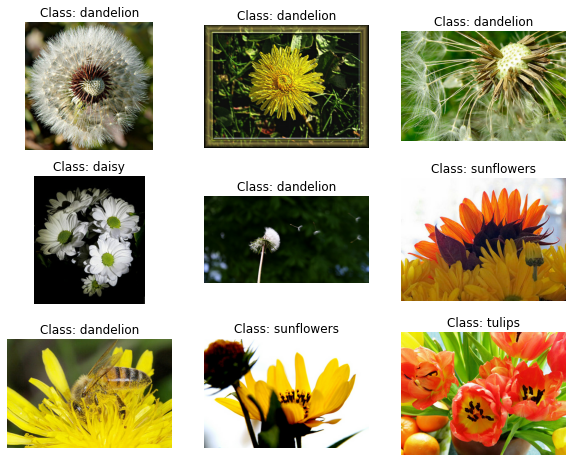

In [9]:
plt.figure(figsize=(10, 8))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

3. 图像预处理

- 基本预处理:对训练集进行乱序，并为所有数据集添加批处理和预取

In [10]:
from keras.utils import np_utils

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    label = tf.cast(label, dtype=tf.int32)
    label = tf.squeeze(label)   # tf.squeeze():用于从张量形状中移除大小为1的维度
    label = tf.one_hot(label, depth=10)
    return resized_image, label

- 进一步预处理:基本预处理的基础上,执行数据增强,即向训练图像添加一些随机变换

In [11]:
# 中央裁切
def central_crop(image):
    shape = tf.shape(image)   # height, width
    min_dim = tf.reduce_min([shape[0], shape[1]])
    
    # 从图像左上到右下
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop    
    
    return image[top_crop:bottom_crop, left_crop:right_crop]    

In [12]:
# 随机裁切
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100

    # 如果一个维度不应该被裁剪，则传递该维度的完整大小
    cropped_image = tf.image.random_crop(image, size=[min_dim, min_dim, 3])
    return cropped_image

In [13]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        # random_flip_left_right:随机水平翻转图像（从左到右）。
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [14]:
batch_size = 32

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

2022-01-24 06:06:26.330606: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


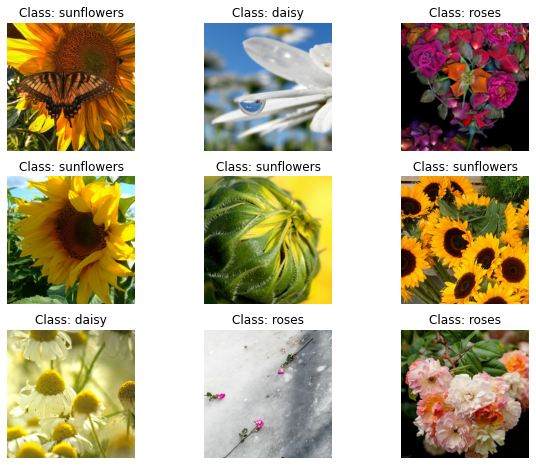

In [15]:
plt.figure(figsize=(10, 8))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

`keras.preprocessing.image.ImageDataGenerator`类可以轻松地从磁盘加载图像并以各种方式增强它们：移动每个图像，旋转，重新缩放，水平或垂直翻转，剪切，或应用任何转换函数。这对于简单的项目非常方便。

然而,构建 `tf.data`流水线有很多优点：它可以从任何来源高效（例如并行）读取图像，而不仅仅是本地磁盘；您可以根据需要操作数据集；如果你写了一个基于 `tf.image` 操作的预处理函数，这个函数既可以在 `tf.data` 流水线中使用，也可以在将要部署到生产环境的模型中使用.

4. 加载预训练模型
    
    加载在 `ImageNet` 上预训练的` Xception` 模型，
    
    `include_top=False`将不包括全局平均池化层和密集输出层,以用于迁移学习

In [16]:
initialization()

In [17]:
from tensorflow.keras.layers import Dense, Softmax, GlobalAvgPool2D
from tensorflow.keras.models import Model, Sequential

In [18]:
feature = keras.applications.xception.Xception(weights='imagenet',
                                               include_top=False)

83697664/83683744 [==============================] - 1s 0us/step


In [19]:
model = Sequential([
    feature,
    GlobalAvgPool2D(),
    Dense(n_classes),
    Softmax()
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


5. 冻结预训练权重

    在前几个轮次时冻结重用层,给新层一些时间来学习.原因是新的输出层是随机初始化的,存在较大的错误,这会破坏重用的权重.不同于`4.6.4.5使用迁移学习训练 Resnet-50`加载的预训练模型已经经过了处理,剔除了无关的参数信息.这里所使用的是`feature`的部分层,因此使用`feature.trainable = False `无效.
    
    在前 5 个 epoch 冻结重用层

In [20]:
for layer in feature.layers:
    layer.trainable = False

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


2022-01-24 06:06:35.088702: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


86/86 [==============================] - 18s 102ms/step - loss: 1.1904 - accuracy: 0.7892 - val_loss: 1.0645 - val_accuracy: 0.8382
Epoch 2/5
86/86 [==============================] - 8s 89ms/step - loss: 0.4923 - accuracy: 0.8968 - val_loss: 0.9263 - val_accuracy: 0.8364
Epoch 3/5
86/86 [==============================] - 8s 89ms/step - loss: 0.3200 - accuracy: 0.9190 - val_loss: 0.7915 - val_accuracy: 0.8640
Epoch 4/5
86/86 [==============================] - 8s 88ms/step - loss: 0.2513 - accuracy: 0.9299 - val_loss: 0.6230 - val_accuracy: 0.8732
Epoch 5/5
86/86 [==============================] - 8s 89ms/step - loss: 0.1853 - accuracy: 0.9466 - val_loss: 0.5692 - val_accuracy: 0.8750


6. 编译,训练模型

In [22]:
for layer in feature.layers:
    layer.trainable = True

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 38s 396ms/step - loss: 0.3484 - accuracy: 0.8884 - val_loss: 0.2582 - val_accuracy: 0.9228
Epoch 2/40
86/86 [==============================] - 34s 390ms/step - loss: 0.1042 - accuracy: 0.9680 - val_loss: 0.2501 - val_accuracy: 0.9062
Epoch 3/40
86/86 [==============================] - 33s 389ms/step - loss: 0.0706 - accuracy: 0.9764 - val_loss: 0.2688 - val_accuracy: 0.9062
Epoch 4/40
86/86 [==============================] - 33s 387ms/step - loss: 0.0741 - accuracy: 0.9771 - val_loss: 0.1961 - val_accuracy: 0.9338
Epoch 5/40
86/86 [==============================] - 33s 386ms/step - loss: 0.0314 - accuracy: 0.9876 - val_loss: 0.2542 - val_accuracy: 0.9136
Epoch 6/40
86/86 [==============================] - 33s 386ms/step - loss: 0.0205 - accuracy: 0.9927 - val_loss: 0.2779 - val_accuracy: 0.9283
Epoch 7/40
86/86 [==============================] - 33s 386ms/step - loss: 0.0302 - accuracy: 0.9895 - val_loss: 0.3494 - val_accuracy: 0.8989